In [1]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from numba import cuda, njit, jit, prange
import numpy as np
from dataclasses import dataclass
import math

import sys
sys.path.append('..')

from utils import plot_multiple_bars

In [2]:
def compute_pi(iterations, num_threads):
    results = np.zeros(num_threads)
    for tid in range(num_threads):
        inside = 0
        for _ in range(iterations):
            x = np.random.random()
            y = np.random.random()
            if x**2 + y**2 <= 1.0:
                inside += 1
        results[tid] = 4.0 * inside / iterations
    return results

def compute_pi_numpy(iterations, num_threads):
    x = np.random.random(size=(num_threads, iterations))
    y = np.random.random(size=(num_threads, iterations))
    inside = (x**2 + y**2) <= 1.0
    counts = inside.sum(axis=1)
    results = 4.0 * counts / iterations
    return results

@njit
def compute_pi_njit(iterations, num_threads):
    results = np.zeros(num_threads)
    for tid in range(num_threads):
        inside = 0
        for _ in range(iterations):
            x = np.random.random()
            y = np.random.random()
            if x**2 + y**2 <= 1.0:
                inside += 1
        results[tid] = 4.0 * inside / iterations
    return results

@njit(parallel=True)
def compute_pi_njit_parallel(iterations, num_threads):
    results = np.zeros(num_threads)
    for tid in prange(num_threads):
        inside = 0
        for _ in prange(iterations):
            x = np.random.random()
            y = np.random.random()
            if x**2 + y**2 <= 1.0:
                inside += 1
        results[tid] = 4.0 * inside / iterations
    return results

@cuda.jit
def compute_pi_cuda(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    tid = cuda.grid(1)

    inside = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, tid)
        y = xoroshiro128p_uniform_float32(rng_states, tid)
        if x**2 + y**2 <= 1.0:
            inside += 1

    out[tid] = 4.0 * inside / iterations

In [3]:
%%timeit -n 1 -r 1 -o

n = 10_000_000
num_threads = 4
results = compute_pi(n, num_threads)
pi_estimate = np.mean(results)
print(f"Оценка числа pi: {pi_estimate}")

Оценка числа pi: 3.1419694
37.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 37.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [4]:
compute_pi_time = _

In [5]:
%%timeit -n 1 -r 10 -o

n = 10_000_000
num_threads = 4
results = compute_pi_numpy(n, num_threads)
pi_estimate = np.mean(results)
# print(f"Оценка числа pi: {pi_estimate}")

705 ms ± 17.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 705 ms ± 17.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [6]:
compute_pi_numpy_time = _

In [7]:
%%timeit -n 1 -r 5 -o

n = 100_000_000
num_threads = 4
results = compute_pi_njit(n, num_threads)
pi_estimate = np.mean(results)
print(f"Оценка числа pi: {pi_estimate}")

Оценка числа pi: 3.14147456
Оценка числа pi: 3.1416452799999997
Оценка числа pi: 3.14151624
Оценка числа pi: 3.14160317
Оценка числа pi: 3.1416917399999997
3.25 s ± 246 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


<TimeitResult : 3.25 s ± 246 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [8]:
compute_pi_njit_time = _

In [9]:
%%timeit -n 1 -r 5 -o

n = 100_000_000
num_threads = 4
results = compute_pi_njit_parallel(n, num_threads)
pi_estimate = np.mean(results)
print(f"Оценка числа pi: {pi_estimate}")

/home/nikita/projects/tobd_project/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Оценка числа pi: 3.1416543
Оценка числа pi: 3.14173003
Оценка числа pi: 3.1415686800000002
Оценка числа pi: 3.14172343
Оценка числа pi: 3.1415164200000003
928 ms ± 241 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


<TimeitResult : 928 ms ± 241 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)>

In [10]:
compute_pi_njit_parallel_time = _

In [11]:
%%timeit -n 1 -r 1 -o

n = 100_000_000
nthreads = 64
nblocks = 24
state_size = nblocks * nthreads
rng_states = create_xoroshiro128p_states(state_size, seed=1)


out = np.zeros(nthreads * nblocks, dtype=np.float32)
compute_pi_cuda[nblocks, nthreads](rng_states, n, out)
print('pi:', out.mean())

/home/nikita/projects/tobd_project/.venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 24 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/nikita/projects/tobd_project/.venv/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


pi: 3.1415894
15.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [12]:
compute_pi_cuda_time = _

In [13]:
@dataclass
class Timings:
    obj: object
    multiplier: int
    
    average: float = 0.0
    stdev: float = 0.0

    def __post_init__(self):
        self.average = self.obj.average * self.multiplier
        self.stdev = self.obj.stdev * self.multiplier

In [14]:
time_results = {
    #"python": Timings(compute_pi_time, 10),
    "numpy": Timings(compute_pi_numpy_time, 10),
    "numba njit": compute_pi_njit_time,
    "numba njit parallel": compute_pi_njit_parallel_time,
    'numba cuda jit': compute_pi_cuda_time,
}

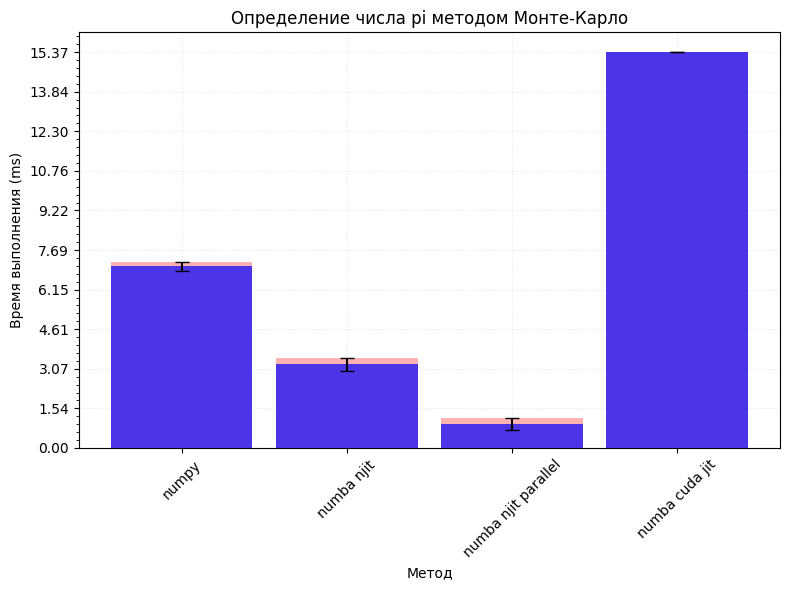

In [15]:
plot_multiple_bars(time_results, title='Определение числа pi методом Монте-Карло', y_title = 'Время выполнения (ms)')

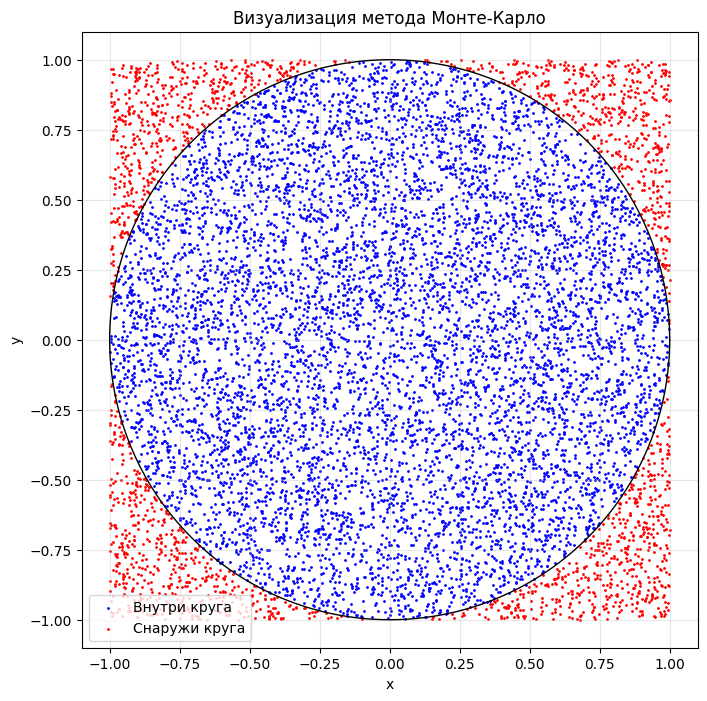

In [23]:
import numpy as np
import matplotlib.pyplot as plt


iterations = 10_000
radius = 1.0


x_points = np.random.uniform(-radius, radius, iterations)
y_points = np.random.uniform(-radius, radius, iterations)


inside = x_points**2 + y_points**2 <= radius**2

plt.figure(figsize=(8, 8))
plt.scatter(
    x_points[inside], y_points[inside], color="blue", s=1, label="Внутри круга"
)
plt.scatter(
    x_points[~inside], y_points[~inside], color="red", s=1, label="Снаружи круга"
)


theta = np.linspace(0, 2 * np.pi, 500)
circle_x = radius * np.cos(theta)
circle_y = radius * np.sin(theta)
plt.plot(circle_x, circle_y, color="black", linewidth=1)


plt.gca().set_aspect("equal", adjustable="box")
plt.title("Визуализация метода Монте-Карло")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
